In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.interpolate import interpn
import cmocean as cm
import gsw

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis



In [3]:
trans = pd.read_csv('/data1/bbeutel/LO_user/ariane/OSM/seasonal_transport.csv')
trans

,Unnamed: 0,section,s17,s18,s19,s20,s21,w17,w18,w19,w20
0,0,North,36001.407662,20739.513205,29694.396204,29249.933502,23714.547157,1222.510471,4075.179788,105.115077,1599.091127
1,1,Offshore,56938.926803,29584.436351,38934.594586,27681.862287,25807.576775,1102.182301,10431.624431,19031.378979,20504.766745
2,2,CUC,32366.554171,53653.118618,44512.177371,49871.143779,58169.463249,35862.749498,27241.888892,21271.018649,22490.881776
3,3,South,11834.052282,12589.428811,2468.254059,6811.668102,10754.783813,39786.676481,35523.825779,31048.652935,34949.001668
4,4,Columbia,366.012450,6109.751725,955.977302,2160.731477,1653.526224,22537.884565,14764.130187,17929.440577,16163.981853
5,5,loop,39988.132894,44638.056786,42853.733619,43595.769762,45740.702593,53822.452719,49359.508083,48512.583298,58123.358084


In [4]:
# lets look at the sections as indexes for ease of analysis
nor = 0
off = 1
cuc = 2
sou = 3
col = 4
loo = 5

In [6]:
tracers = pd.read_csv('/data1/bbeutel/LO_user/ariane/OSM/tracers.csv')
tracers.head()

,Unnamed: 0,salt,temperature,NO3,oxygen,transport,depth,season,year,section
0,3,30.715387,9.134833,15.741662,270.217407,0.002187,18.089465,summer,2017.0,loop
1,51,27.029570,10.487689,4.025189,321.115540,0.002511,2.196340,summer,2017.0,loop
2,101,29.024899,9.943184,7.286023,311.617767,0.002381,5.138868,summer,2017.0,loop
3,2690,29.043703,9.957072,7.441795,310.305695,0.002384,5.637972,summer,2017.0,loop
4,2790,28.461721,10.375201,4.149877,316.328979,0.002484,17.259097,summer,2017.0,loop


In [32]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df.salt[df.section == region].reset_index(drop=True)
    temp = df.temperature[df.section == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(salt))
    ax.set_title(title)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)


############
# ELLIPSES #
############

def percentile_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, mean, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, facecolor='none', **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    return subset_mean[0], subset_mean[1], width, height, angle
    

# Summer

In [7]:
# summer mean
Snorth = np.mean([trans.s17[nor],trans.s18[nor],trans.s19[nor],trans.s20[nor],trans.s21[nor]])
Ssouth = np.mean([trans.s17[sou],trans.s18[sou],trans.s19[sou],trans.s20[sou],trans.s21[sou]])
Soffshore = np.mean([trans.s17[off],trans.s18[off],trans.s19[off],trans.s20[off],trans.s21[off]])
Scuc = np.mean([trans.s17[cuc],trans.s18[cuc],trans.s19[cuc],trans.s20[cuc],trans.s21[cuc]])
Scol = np.mean([trans.s17[col],trans.s18[col],trans.s19[col],trans.s20[col],trans.s21[col]])
Sloop = np.mean([trans.s17[loo],trans.s18[loo],trans.s19[loo],trans.s20[loo],trans.s21[loo]])

/tmp/ipykernel_135943/1255929914.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/1255929914.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/1255929914.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')


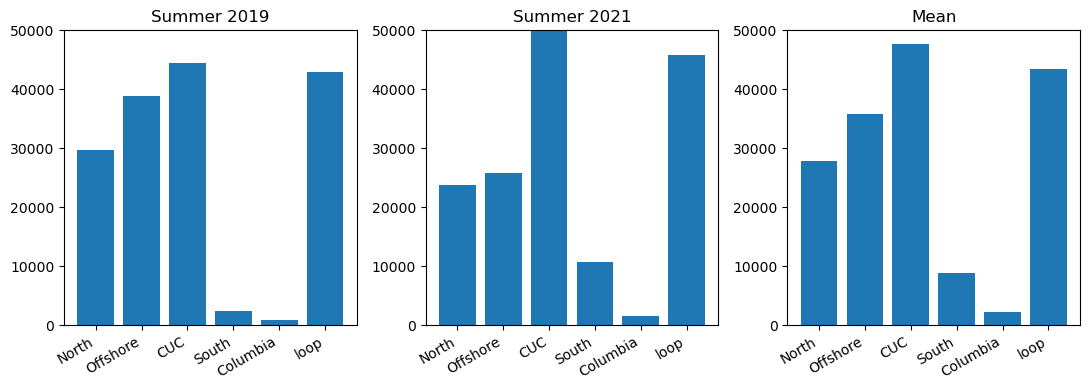

In [8]:
fig, ax = plt.subplots(1,3,figsize=(11,4))

sources = ['North','Offshore','CUC','South','Columbia','loop']

ax[0].bar(sources,[trans.s19[nor],trans.s19[off],trans.s19[cuc],trans.s19[sou],trans.s19[col],trans.s19[loo]])
ax[1].bar(sources,[trans.s21[nor],trans.s21[off],trans.s21[cuc],trans.s21[sou],trans.s21[col],trans.s21[loo]])
ax[2].bar(sources,[Snorth,Soffshore,Scuc,Ssouth,Scol,Sloop])

ax[0].set_title('Summer 2019') # high O2 summer
ax[1].set_title('Summer 2021') # hypoxia summer
ax[2].set_title('Mean')

for axs in ax:
    axs.set_ylim([0,50000])
    axs.set_xticklabels(sources,rotation=30, ha='right')

plt.tight_layout()

In [9]:
np.array([Snorth,Soffshore,Scuc,Ssouth,Scol,Sloop])/1000

array([27.87995955, 35.78947936, 47.71449144,  8.89163741,  2.24919984,
       43.36327913])

159.4191331398549
165.8405998121071
165.88804672424234


/tmp/ipykernel_135943/2437448247.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/2437448247.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/2437448247.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')


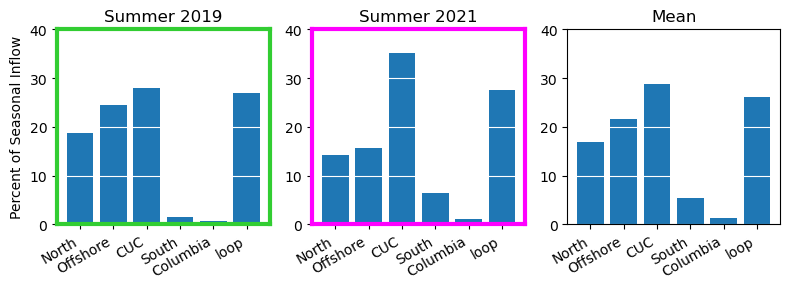

In [10]:
# same thing but percentages
fig, ax = plt.subplots(1,3,figsize=(8,3))

sources = ['North','Offshore','CUC','South','Columbia','loop']

total = np.sum([trans.s19[nor],trans.s19[off],trans.s19[cuc],trans.s19[sou],trans.s19[col],trans.s19[loo]])
print(total/1000)
ax[0].bar(sources,[100*(trans.s19[nor]/total),100*(trans.s19[off]/total),100*(trans.s19[cuc]/total),100*(trans.s19[sou]/total),100*(trans.s19[col]/total),100*(trans.s19[loo]/total)])
total = np.sum([trans.s21[nor],trans.s21[off],trans.s21[cuc],trans.s21[sou],trans.s21[col],trans.s21[loo]])
print(total/1000)
ax[1].bar(sources,[(trans.s21[nor]/total)*100,(trans.s21[off]/total)*100,(trans.s21[cuc]/total)*100,(trans.s21[sou]/total)*100,(trans.s21[col]/total)*100,(trans.s21[loo]/total)*100])
total = np.sum([Snorth,Soffshore,Scuc,Ssouth,Scol,Sloop])
print(total/1000)
ax[2].bar(sources,[(Snorth/total)*100,(Soffshore/total)*100,(Scuc/total)*100,(Ssouth/total)*100,(Scol/total)*100,(Sloop/total)*100])

ax[0].set_title('Summer 2019') # high O2 summer
ax[1].set_title('Summer 2021') # hypoxia summer
ax[2].set_title('Mean')
ax[0].set_ylabel('Percent of Seasonal Inflow')

for axs in ax:
    axs.set_ylim([0,40])
    axs.set_xticklabels(sources,rotation=30, ha='right')
    axs.grid(axis='y',color='w')

#make border match dot colour
for spine in ax[0].spines.values():
        spine.set_edgecolor('limegreen')
        spine.set_linewidth(3)

#make border match dot colour
for spine in ax[1].spines.values():
        spine.set_edgecolor('magenta')
        spine.set_linewidth(3)

plt.tight_layout()
# plt.savefig("./figures/summerbar.jpg")


/tmp/ipykernel_135943/3026331109.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sources,rotation=30, ha='right')


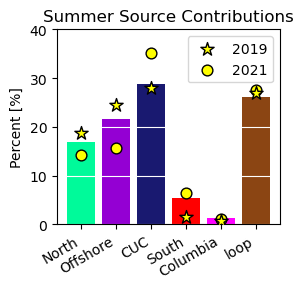

In [12]:
# same thing but just one bar plot and colour coding
fig, ax = plt.subplots(1,1,figsize=(3,3))

sources = ['North','Offshore','CUC','South','Columbia','loop']
colours = ['mediumspringgreen','darkviolet','midnightblue','red','magenta','saddlebrown'] 

total = np.sum([trans.s19[nor],trans.s19[off],trans.s19[cuc],trans.s19[sou],trans.s19[col],trans.s19[loo]])
ax.scatter(sources,[100*(trans.s19[nor]/total),100*(trans.s19[off]/total),100*(trans.s19[cuc]/total),100*(trans.s19[sou]/total),100*(trans.s19[col]/total),100*(trans.s19[loo]/total)],zorder=3,marker='*',edgecolors='k',s=100,color='yellow', label='2019')
total = np.sum([trans.s21[nor],trans.s21[off],trans.s21[cuc],trans.s21[sou],trans.s21[col],trans.s21[loo]])
ax.scatter(sources,[(trans.s21[nor]/total)*100,(trans.s21[off]/total)*100,(trans.s21[cuc]/total)*100,(trans.s21[sou]/total)*100,(trans.s21[col]/total)*100,(trans.s21[loo]/total)*100],zorder=2,marker='o',edgecolors='k',s=60,color='yellow', label='2021')
total = np.sum([Snorth,Soffshore,Scuc,Ssouth,Scol,Sloop])
ax.bar(sources,[(Snorth/total)*100,(Soffshore/total)*100,(Scuc/total)*100,(Ssouth/total)*100,(Scol/total)*100,(Sloop/total)*100],color=colours,zorder=1)

ax.set_title('Summer Source Contributions')
ax.set_ylabel('Percent [%]')
ax.set_ylim([0,40])
ax.set_xticklabels(sources,rotation=30, ha='right')
ax.grid(axis='y',color='w')
ax.legend()

plt.tight_layout()
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/summerbar.jpg")


In [31]:
tracers

,Unnamed: 0,salt,temperature,NO3,oxygen,transport,depth,season,year,section
0,3,30.715387,9.134833,15.741662,270.217407,0.002187,18.089465,summer,2017.0,loop
1,51,27.029570,10.487689,4.025189,321.115540,0.002511,2.196340,summer,2017.0,loop
2,101,29.024899,9.943184,7.286023,311.617767,0.002381,5.138868,summer,2017.0,loop
3,2690,29.043703,9.957072,7.441795,310.305695,0.002384,5.637972,summer,2017.0,loop
4,2790,28.461721,10.375201,4.149877,316.328979,0.002484,17.259097,summer,2017.0,loop
...,...,...,...,...,...,...,...,...,...,...
5521743,27783850,33.931908,6.013258,37.014473,67.675369,0.001099,300.929977,summer,2021.0,cuc
5521744,27783851,33.730835,6.766821,35.753952,74.706940,0.001237,209.389412,summer,2021.0,offshore
5521745,27783852,33.626270,6.869098,32.157604,103.501343,0.001255,187.336988,summer,2021.0,offshore
5521746,27783853,33.709015,6.644220,34.020500,89.047768,0.001214,203.245262,summer,2021.0,cuc


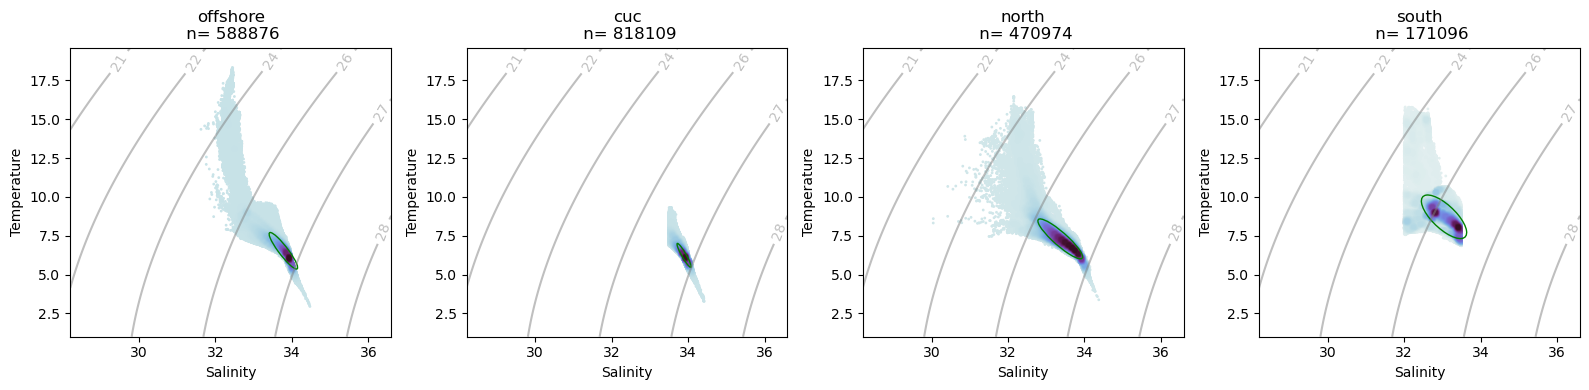

In [37]:
# TS digrams with ellipse
regions = ['offshore','cuc','north','south']
x_mean, y_mean, width, height, angle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS(tracers[tracers.season == 'summer'],regions[i],ax[i])
    x_mean[i], y_mean[i], width[i], height[i], angle[i] = percentile_ellipse(np.array(tracers.salt[(tracers.season == 'summer') & (tracers.section == regions[i])]), np.array(tracers.temperature[(tracers.season == 'summer') & (tracers.section == regions[i])]), ax[i], percentile=75, edgecolor='green')
plt.tight_layout()

In [38]:
print(x_mean)
print(y_mean)
print(width)
print(height)
print(angle)



[33.77666864 33.89333029 33.36770561 33.04148093]
[6.5316104  6.23492864 7.29841359 8.71926518]
[2.45040867 1.5795744  2.78031865 2.94314504]
[0.28385222 0.12860834 0.47280694 0.78123976]
[106.47423903 102.71199375 113.00224522 108.30265367]


In [ ]:
# what if the TS diagram was a histogram instead?


In [13]:
summer_salt = [tracers.salt[(tracers.section=='north')&(tracers.season=='summer')],
               tracers.salt[(tracers.section=='offshore')&(tracers.season=='summer')],
               tracers.salt[(tracers.section=='cuc')&(tracers.season=='summer')],
               tracers.salt[(tracers.section=='south')&(tracers.season=='summer')],
               tracers.salt[(tracers.section=='columbia')&(tracers.season=='summer')],
               tracers.salt[(tracers.section=='loop')&(tracers.season=='summer')]]

s19_salt = [np.average(tracers.salt[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.salt[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.salt[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.salt[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.salt[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.salt[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)])]

s21_salt = [np.average(tracers.salt[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.salt[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.salt[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.salt[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.salt[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.salt[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)])]

summer_temp = [tracers.temperature[(tracers.section=='north')&(tracers.season=='summer')],
               tracers.temperature[(tracers.section=='offshore')&(tracers.season=='summer')],
               tracers.temperature[(tracers.section=='cuc')&(tracers.season=='summer')],
               tracers.temperature[(tracers.section=='south')&(tracers.season=='summer')],
               tracers.temperature[(tracers.section=='columbia')&(tracers.season=='summer')],
               tracers.temperature[(tracers.section=='loop')&(tracers.season=='summer')]]

s19_temp = [np.average(tracers.temperature[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.temperature[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.temperature[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.temperature[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.temperature[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.temperature[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)])]

s21_temp = [np.average(tracers.temperature[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.temperature[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.temperature[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.temperature[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.temperature[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.temperature[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)])]

summer_no3 = [tracers.NO3[(tracers.section=='north')&(tracers.season=='summer')],
               tracers.NO3[(tracers.section=='offshore')&(tracers.season=='summer')],
               tracers.NO3[(tracers.section=='cuc')&(tracers.season=='summer')],
               tracers.NO3[(tracers.section=='south')&(tracers.season=='summer')],
               tracers.NO3[(tracers.section=='columbia')&(tracers.season=='summer')],
               tracers.NO3[(tracers.section=='loop')&(tracers.season=='summer')]]

s19_no3 = [np.average(tracers.NO3[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.NO3[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.NO3[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.NO3[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.NO3[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.NO3[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)])]

s21_no3 = [np.average(tracers.NO3[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.NO3[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.NO3[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.NO3[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.NO3[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.NO3[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)])]

summer_oxy = [tracers.oxygen[(tracers.section=='north')&(tracers.season=='summer')],
               tracers.oxygen[(tracers.section=='offshore')&(tracers.season=='summer')],
               tracers.oxygen[(tracers.section=='cuc')&(tracers.season=='summer')],
               tracers.oxygen[(tracers.section=='south')&(tracers.season=='summer')],
               tracers.oxygen[(tracers.section=='columbia')&(tracers.season=='summer')],
               tracers.oxygen[(tracers.section=='loop')&(tracers.season=='summer')]]

s19_oxy = [np.average(tracers.oxygen[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.oxygen[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.oxygen[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.oxygen[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.oxygen[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2019)]),
               np.average(tracers.oxygen[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2019)])]

s21_oxy = [np.average(tracers.oxygen[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.oxygen[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.oxygen[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.oxygen[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.oxygen[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='summer')&(tracers.year==2021)]),
               np.average(tracers.oxygen[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='summer')&(tracers.year==2021)])]

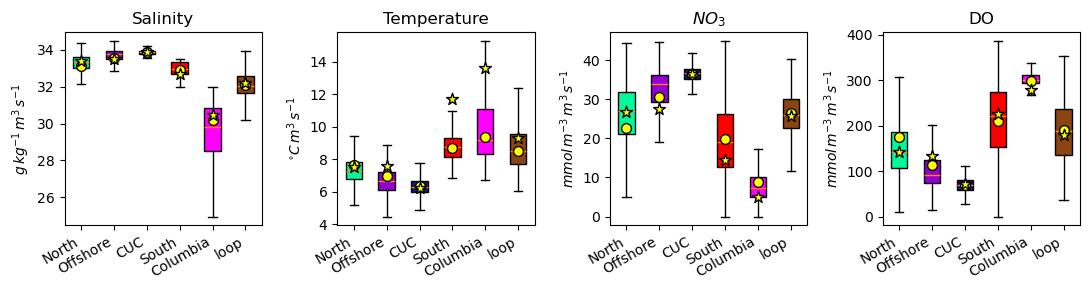

In [14]:
# box limits are quartiles
# first quartile (Q1), is the value under which 25% of data points are found when they are arranged in increasing order
# third quartile (Q3), is the value under which 75% of data points are found when arranged in increasing order
# the whiskers are based on the equation Q3 + whis*(Q3-Q1) and Q1 - whis*(Q3-Q1)

fig, ax = plt.subplots(1,4,figsize=(11,3))

# salt
bplot1 = ax[0].boxplot(summer_salt,showfliers=False,patch_artist=True)
ax[0].set_xticklabels(sources)
ax[0].set_title('Salinity')
ax[0].set_ylabel('$g\, kg^{-1}\, m^3\, s^{-1}$')

# temp
bplot2 = ax[1].boxplot(summer_temp,showfliers=False,patch_artist=True)
ax[1].set_xticklabels(sources)
ax[1].set_title('Temperature')
ax[1].set_ylabel('$^{\circ}C\, m^3\, s^{-1}$')

# no3
bplot3 = ax[2].boxplot(summer_no3,showfliers=False,patch_artist=True)
ax[2].set_xticklabels(sources)
ax[2].set_title('$NO_3$')
ax[2].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# oxygen
bplot4 = ax[3].boxplot(summer_oxy,showfliers=False,patch_artist=True)
ax[3].set_xticklabels(sources)
ax[3].set_title('DO')
ax[3].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# fill with colors
colors = colours
for bplot in (bplot1, bplot2, bplot3, bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# year of interest
ax[0].scatter(np.arange(6)+1, s19_salt, color='yellow', edgecolor='k', marker='*',s=80,zorder=4, label='Summer 2019')
ax[1].scatter(np.arange(6)+1,s19_temp, color='yellow', edgecolor='k', marker='*',s=80,zorder=4)
ax[2].scatter(np.arange(6)+1,s19_no3, color='yellow', edgecolor='k', marker='*',s=80,zorder=4)
ax[3].scatter(np.arange(6)+1,s19_oxy, color='yellow', edgecolor='k', marker='*',s=80,zorder=4)

ax[0].scatter(np.arange(6)+1,s21_salt, color='yellow',edgecolor='k',marker='o', s=50, zorder=3, label='Summer 2021')
ax[1].scatter(np.arange(6)+1,s21_temp, color='yellow',edgecolor='k',marker='o', s=50, zorder=3)
ax[2].scatter(np.arange(6)+1,s21_no3, color='yellow',edgecolor='k',marker='o', s=50, zorder=3)
ax[3].scatter(np.arange(6)+1,s21_oxy, color='yellow',edgecolor='k',marker='o', s=50, zorder=3)

# ax[0].legend()

for axs in ax:
    axs.set_xticklabels(sources,rotation=30, ha='right')

plt.tight_layout()
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/summerbox.jpg")


In [15]:
# winter mean
Wnorth = np.mean([trans.w17[nor],trans.w18[nor],trans.w19[nor],trans.w20[nor]])
Wsouth = np.mean([trans.w17[sou],trans.w18[sou],trans.w19[sou],trans.w20[sou]])
Woffshore = np.mean([trans.w17[off],trans.w18[off],trans.w19[off],trans.w20[off]])
Wcuc = np.mean([trans.w17[cuc],trans.w18[cuc],trans.w19[cuc],trans.w20[cuc]])
Wcol = np.mean([trans.w17[col],trans.w18[col],trans.w19[col],trans.w20[col]])
Wloop = np.mean([trans.w17[loo],trans.w18[loo],trans.w19[loo],trans.w20[loo]])

/tmp/ipykernel_135943/1031146654.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/1031146654.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/1031146654.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')


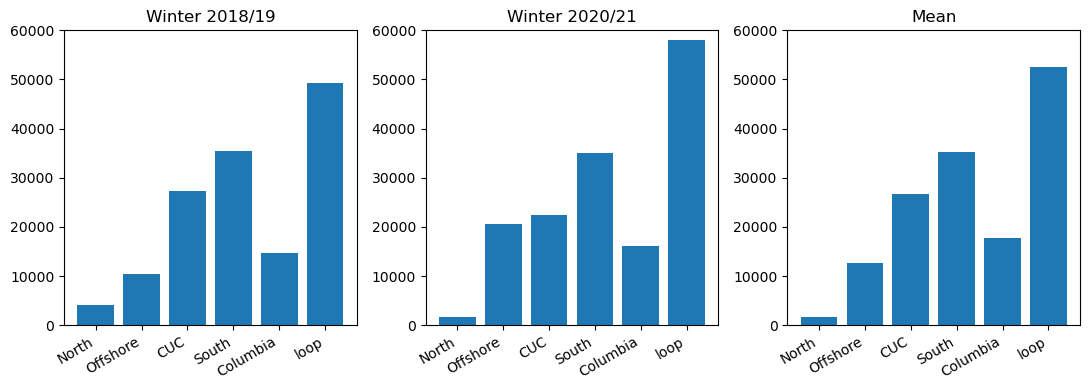

In [16]:
fig, ax = plt.subplots(1,3,figsize=(11,4))

sources = ['North','Offshore','CUC','South','Columbia','loop']

ax[0].bar(sources,[trans.w18[nor],trans.w18[off],trans.w18[cuc],trans.w18[sou],trans.w18[col],trans.w18[loo]])
ax[1].bar(sources,[trans.w20[nor],trans.w20[off],trans.w20[cuc],trans.w20[sou],trans.w20[col],trans.w20[loo]])
ax[2].bar(sources,[Wnorth, Woffshore,Wcuc,Wsouth,Wcol,Wloop])

ax[0].set_title('Winter 2018/19') # strong downwelling winter
ax[1].set_title('Winter 2020/21') # weak downwelling winter
ax[2].set_title('Mean')

for axs in ax:
    axs.set_ylim([0,60000])
    axs.set_xticklabels(sources,rotation=30, ha='right')

plt.tight_layout()

In [17]:
np.array([Wnorth, Woffshore,Wcuc,Wsouth,Wcol,Wloop])/1000

array([ 1.75047412, 12.76748811, 26.7166347 , 35.32703922, 17.8488593 ,
       52.45447555])

141.396157159187
153.83108125220568
146.8649709905386


/tmp/ipykernel_135943/2445091862.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/2445091862.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')
/tmp/ipykernel_135943/2445091862.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sources,rotation=30, ha='right')


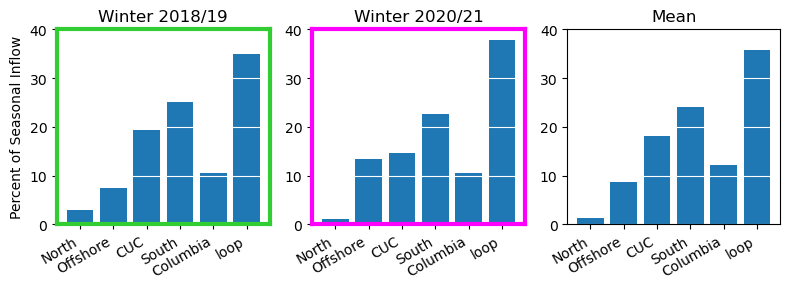

In [18]:
# same thing but percentages
fig, ax = plt.subplots(1,3,figsize=(8,3))

sources = ['North','Offshore','CUC','South','Columbia','loop']

total = np.sum([trans.w18[nor],trans.w18[off],trans.w18[cuc],trans.w18[sou],trans.w18[col],trans.w18[loo]])
print(total/1000)
ax[0].bar(sources,[100*(trans.w18[nor]/total),100*(trans.w18[off]/total),100*(trans.w18[cuc]/total),100*(trans.w18[sou]/total),100*(trans.w18[col]/total),100*(trans.w18[loo]/total)])
total = np.sum([trans.w20[nor],trans.w20[off],trans.w20[cuc],trans.w20[sou],trans.w20[col],trans.w20[loo]])
print(total/1000)
ax[1].bar(sources,[(trans.w20[nor]/total)*100,(trans.w20[off]/total)*100,(trans.w20[cuc]/total)*100,(trans.w20[sou]/total)*100,(trans.w20[col]/total)*100,(trans.w20[loo]/total)*100])
total = np.sum([Wnorth, Woffshore,Wcuc,Wsouth,Wcol,Wloop])
print(total/1000)
ax[2].bar(sources,[(Wnorth/total)*100,(Woffshore/total)*100,(Wcuc/total)*100,(Wsouth/total)*100,(Wcol/total)*100,(Wloop/total)*100])

ax[0].set_title('Winter 2018/19') # strong downwelling winter
ax[1].set_title('Winter 2020/21') # weak downwelling winter
ax[2].set_title('Mean')
ax[0].set_ylabel('Percent of Seasonal Inflow')

for axs in ax:
    axs.set_ylim([0,40])
    axs.set_xticklabels(sources,rotation=30, ha='right')
    axs.grid(axis='y',color='w')

#make border match dot colour
for spine in ax[0].spines.values():
        spine.set_edgecolor('limegreen')
        spine.set_linewidth(3)

#make border match dot colour
for spine in ax[1].spines.values():
        spine.set_edgecolor('magenta')
        spine.set_linewidth(3)

plt.tight_layout()
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/winterbar.jpg")


/tmp/ipykernel_135943/841675560.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sources,rotation=30, ha='right')


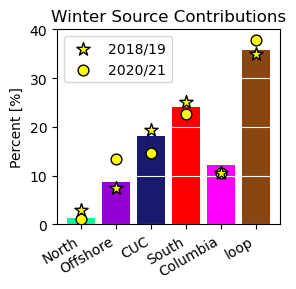

In [19]:
# same thing but just one bar plot and colour coding
fig, ax = plt.subplots(1,1,figsize=(3,3))

sources = ['North','Offshore','CUC','South','Columbia','loop']
colours = ['mediumspringgreen','darkviolet','midnightblue','red','magenta','saddlebrown'] 

total = np.sum([trans.w18[nor],trans.w18[off],trans.w18[cuc],trans.w18[sou],trans.w18[col],trans.w18[loo]])
ax.scatter(sources,[100*(trans.w18[nor]/total),100*(trans.w18[off]/total),100*(trans.w18[cuc]/total),100*(trans.w18[sou]/total),100*(trans.w18[col]/total),100*(trans.w18[loo]/total)],zorder=3,marker='*',edgecolors='k',s=100,color='yellow', label='2018/19')
total = np.sum([trans.w20[nor],trans.w20[off],trans.w20[cuc],trans.w20[sou],trans.w20[col],trans.w20[loo]])
ax.scatter(sources,[(trans.w20[nor]/total)*100,(trans.w20[off]/total)*100,(trans.w20[cuc]/total)*100,(trans.w20[sou]/total)*100,(trans.w20[col]/total)*100,(trans.w20[loo]/total)*100],zorder=2,marker='o',edgecolors='k',s=60,color='yellow', label='2020/21')
total = np.sum([Wnorth, Woffshore,Wcuc,Wsouth,Wcol,Wloop])
ax.bar(sources,[(Wnorth/total)*100,(Woffshore/total)*100,(Wcuc/total)*100,(Wsouth/total)*100,(Wcol/total)*100,(Wloop/total)*100],color=colours,zorder=1)

ax.set_title('Winter Source Contributions')
ax.set_ylabel('Percent [%]')
ax.set_ylim([0,40])
ax.set_xticklabels(sources,rotation=30, ha='right')
ax.grid(axis='y',color='w')

ax.legend()

plt.tight_layout()
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/winterbar.jpg")

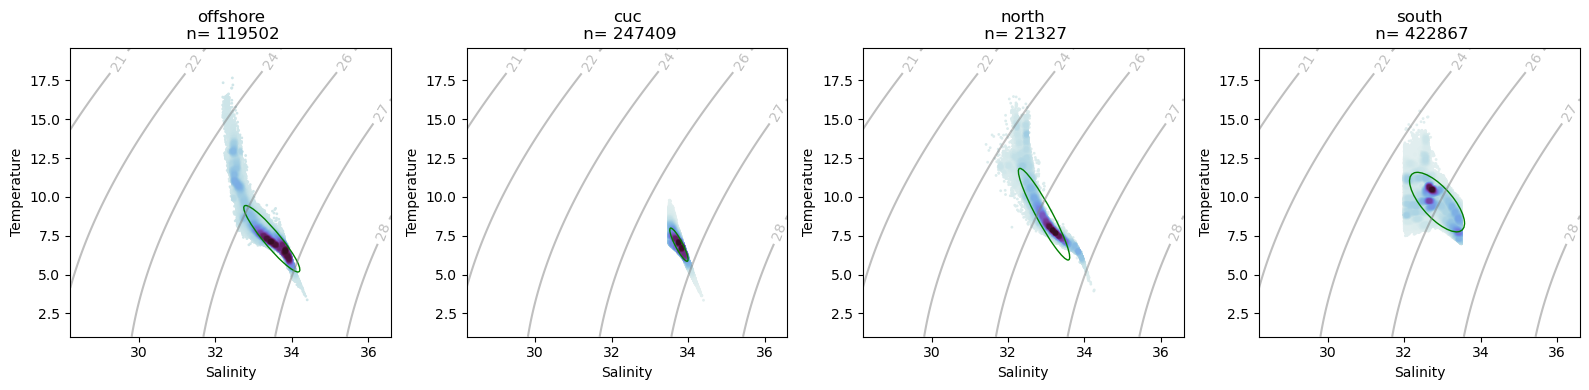

In [39]:
# TS digrams with ellipse
regions = ['offshore','cuc','north','south']
x_mean, y_mean, width, height, angle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS(tracers[tracers.season == 'winter'],regions[i],ax[i])
    x_mean[i], y_mean[i], width[i], height[i], angle[i] = percentile_ellipse(np.array(tracers.salt[(tracers.season == 'winter') & (tracers.section == regions[i])]), np.array(tracers.temperature[(tracers.season == 'winter') & (tracers.section == regions[i])]), ax[i], percentile=75, edgecolor='green')
plt.tight_layout()

In [40]:
print(x_mean)
print(y_mean)
print(width)
print(height)
print(angle)

[33.47413938 33.7584284  32.94355931 32.85874228]
[7.30605078 6.92505309 8.88523306 9.66397407]
[4.49170249 2.17786067 6.0291546  3.97315797]
[0.51230721 0.21507746 0.45909681 0.97210777]
[107.95369756 101.38173202 102.12228685 105.99137396]


In [20]:
winter_salt = [tracers.salt[(tracers.section=='north')&(tracers.season=='winter')],
               tracers.salt[(tracers.section=='offshore')&(tracers.season=='winter')],
               tracers.salt[(tracers.section=='cuc')&(tracers.season=='winter')],
               tracers.salt[(tracers.section=='south')&(tracers.season=='winter')],
               tracers.salt[(tracers.section=='columbia')&(tracers.season=='winter')],
               tracers.salt[(tracers.section=='loop')&(tracers.season=='winter')]]

w18_salt = [np.average(tracers.salt[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.salt[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.salt[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.salt[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.salt[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.salt[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)])]

w20_salt = [np.average(tracers.salt[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.salt[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.salt[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.salt[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.salt[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.salt[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)])]

winter_temp = [tracers.temperature[(tracers.section=='north')&(tracers.season=='winter')],
               tracers.temperature[(tracers.section=='offshore')&(tracers.season=='winter')],
               tracers.temperature[(tracers.section=='cuc')&(tracers.season=='winter')],
               tracers.temperature[(tracers.section=='south')&(tracers.season=='winter')],
               tracers.temperature[(tracers.section=='columbia')&(tracers.season=='winter')],
               tracers.temperature[(tracers.section=='loop')&(tracers.season=='winter')]]

w18_temp = [np.average(tracers.temperature[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.temperature[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.temperature[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.temperature[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.temperature[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.temperature[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)])]

w20_temp = [np.average(tracers.temperature[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.temperature[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.temperature[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.temperature[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.temperature[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.temperature[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)])]

winter_no3 = [tracers.NO3[(tracers.section=='north')&(tracers.season=='winter')],
               tracers.NO3[(tracers.section=='offshore')&(tracers.season=='winter')],
               tracers.NO3[(tracers.section=='cuc')&(tracers.season=='winter')],
               tracers.NO3[(tracers.section=='south')&(tracers.season=='winter')],
               tracers.NO3[(tracers.section=='columbia')&(tracers.season=='winter')],
               tracers.NO3[(tracers.section=='loop')&(tracers.season=='winter')]]

w18_no3 = [np.average(tracers.NO3[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.NO3[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.NO3[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.NO3[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.NO3[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.NO3[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)])]

w20_no3 = [np.average(tracers.NO3[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.NO3[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.NO3[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.NO3[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.NO3[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.NO3[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)])]

winter_oxy = [tracers.oxygen[(tracers.section=='north')&(tracers.season=='winter')],
               tracers.oxygen[(tracers.section=='offshore')&(tracers.season=='winter')],
               tracers.oxygen[(tracers.section=='cuc')&(tracers.season=='winter')],
               tracers.oxygen[(tracers.section=='south')&(tracers.season=='winter')],
               tracers.oxygen[(tracers.section=='columbia')&(tracers.season=='winter')],
               tracers.oxygen[(tracers.section=='loop')&(tracers.season=='winter')]]

w18_oxy = [np.average(tracers.oxygen[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.oxygen[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.oxygen[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.oxygen[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.oxygen[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2018)]),
               np.average(tracers.oxygen[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2018)])]

w20_oxy = [np.average(tracers.oxygen[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='north')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.oxygen[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.oxygen[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.oxygen[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='south')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.oxygen[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')&(tracers.year==2020)]),
               np.average(tracers.oxygen[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)],weights=tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')&(tracers.year==2020)])]

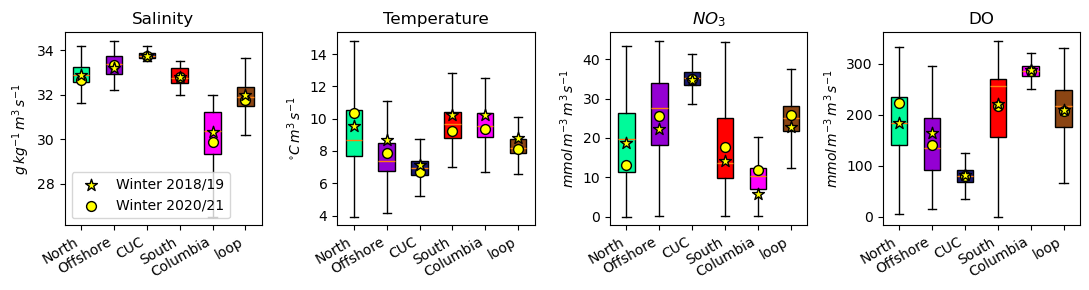

In [21]:
# box limits are quartiles
# first quartile (Q1), is the value under which 25% of data points are found when they are arranged in increasing order
# third quartile (Q3), is the value under which 75% of data points are found when arranged in increasing order
# the whiskers are based on the equation Q3 + whis*(Q3-Q1) and Q1 - whis*(Q3-Q1)

fig, ax = plt.subplots(1,4,figsize=(11,3))

# salt
bplot1 = ax[0].boxplot(winter_salt,showfliers=False,patch_artist=True)
ax[0].set_xticklabels(sources)
ax[0].set_title('Salinity')
ax[0].set_ylabel('$g\, kg^{-1}\, m^3\, s^{-1}$')

# temp
bplot2 = ax[1].boxplot(winter_temp,showfliers=False,patch_artist=True)
ax[1].set_xticklabels(sources)
ax[1].set_title('Temperature')
ax[1].set_ylabel('$^{\circ}C\, m^3\, s^{-1}$')

# no3
bplot3 = ax[2].boxplot(winter_no3,showfliers=False,patch_artist=True)
ax[2].set_xticklabels(sources)
ax[2].set_title('$NO_3$')
ax[2].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# oxygen
bplot4 = ax[3].boxplot(winter_oxy,showfliers=False,patch_artist=True)
ax[3].set_xticklabels(sources)
ax[3].set_title('DO')
ax[3].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# fill with colors
colors = colours
for bplot in (bplot1, bplot2, bplot3, bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# year of interest
ax[0].scatter(np.arange(6)+1, w18_salt, color='yellow', edgecolor='k', marker='*',s=80,zorder=4, label='Winter 2018/19')
ax[1].scatter(np.arange(6)+1,w18_temp, color='yellow', edgecolor='k', marker='*',s=80,zorder=4)
ax[2].scatter(np.arange(6)+1,w18_no3, color='yellow', edgecolor='k', marker='*',s=80,zorder=4)
ax[3].scatter(np.arange(6)+1,w18_oxy, color='yellow', edgecolor='k', marker='*',s=80,zorder=4)

ax[0].scatter(np.arange(6)+1,w20_salt, color='yellow',edgecolor='k',marker='o', s=50, zorder=3, label='Winter 2020/21')
ax[1].scatter(np.arange(6)+1,w20_temp, color='yellow',edgecolor='k',marker='o', s=50, zorder=3)
ax[2].scatter(np.arange(6)+1,w20_no3, color='yellow',edgecolor='k',marker='o', s=50, zorder=3)
ax[3].scatter(np.arange(6)+1,w20_oxy, color='yellow',edgecolor='k',marker='o', s=50, zorder=3)

ax[0].legend()

for axs in ax:
    axs.set_xticklabels(sources,rotation=30, ha='right')

plt.tight_layout()
plt.savefig("/data1/bbeutel/LO_user/ariane/figures/winterbox.jpg")

In [22]:
winter_tran = [np.array(tracers.transport[(tracers.section=='north')&(tracers.season=='winter')]),
               np.array(tracers.transport[(tracers.section=='offshore')&(tracers.season=='winter')]),
               np.array(tracers.transport[(tracers.section=='cuc')&(tracers.season=='winter')]),
               np.array(tracers.transport[(tracers.section=='south')&(tracers.season=='winter')]),
               np.array(tracers.transport[(tracers.section=='columbia')&(tracers.season=='winter')]),
               np.array(tracers.transport[(tracers.section=='loop')&(tracers.season=='winter')])]

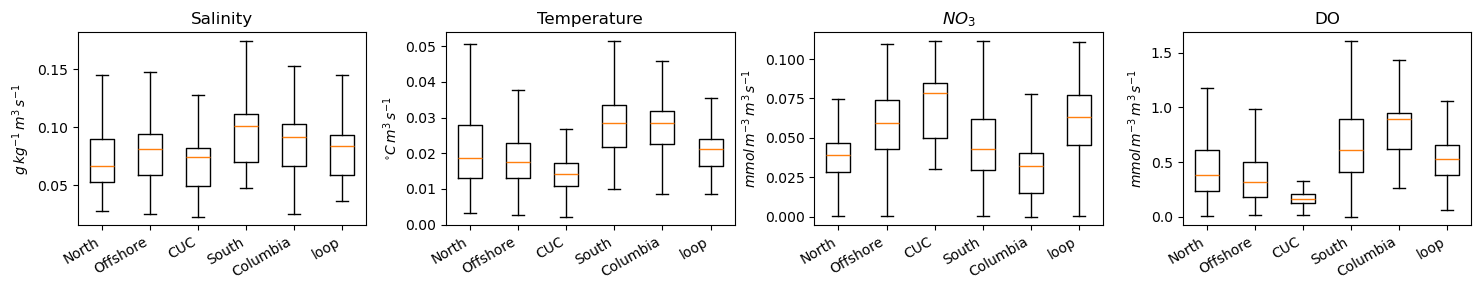

In [23]:
# same thing but weighted by transport
fig, ax = plt.subplots(1,4,figsize=(15,3))

# salt
ax[0].boxplot([winter_salt[i]*winter_tran[i] for i in range(len(winter_tran))],showfliers=False)
ax[0].set_xticklabels(sources)
ax[0].set_title('Salinity')
ax[0].set_ylabel('$g\, kg^{-1}\, m^3\, s^{-1}$')

# temp
ax[1].boxplot([winter_temp[i]*winter_tran[i] for i in range(len(winter_tran))],showfliers=False)
ax[1].set_xticklabels(sources)
ax[1].set_title('Temperature')
ax[1].set_ylabel('$^{\circ}C\, m^3\, s^{-1}$')

# no3
ax[2].boxplot([winter_no3[i]*winter_tran[i] for i in range(len(winter_tran))],showfliers=False)
ax[2].set_xticklabels(sources)
ax[2].set_title('$NO_3$')
ax[2].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# oxygen
ax[3].boxplot([winter_oxy[i]*winter_tran[i] for i in range(len(winter_tran))],showfliers=False)
ax[3].set_xticklabels(sources)
ax[3].set_title('DO')
ax[3].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# # year of interest
# ax[0].scatter(np.arange(6)+1, w18_salt, color='yellow', edgecolor='k', marker='*',s=100, label='Winter 2018/19')
# ax[1].scatter(np.arange(6)+1,w18_temp, color='yellow', edgecolor='k', marker='*',s=100)
# ax[2].scatter(np.arange(6)+1,w18_no3, color='yellow', edgecolor='k', marker='*',s=100)
# ax[3].scatter(np.arange(6)+1,w18_oxy, color='yellow', edgecolor='k', marker='*',s=100)

# ax[0].scatter(np.arange(6)+1,w20_salt, color='yellow',edgecolor='k',marker='o', s=60, label='Winter 2020/21')
# ax[1].scatter(np.arange(6)+1,w20_temp, color='yellow',edgecolor='k',marker='o', s=60)
# ax[2].scatter(np.arange(6)+1,w20_no3, color='yellow',edgecolor='k',marker='o', s=60)
# ax[3].scatter(np.arange(6)+1,w20_oxy, color='yellow',edgecolor='k',marker='o', s=60)

# ax[0].legend()

for axs in ax:
    axs.set_xticklabels(sources,rotation=30, ha='right')

plt.tight_layout()

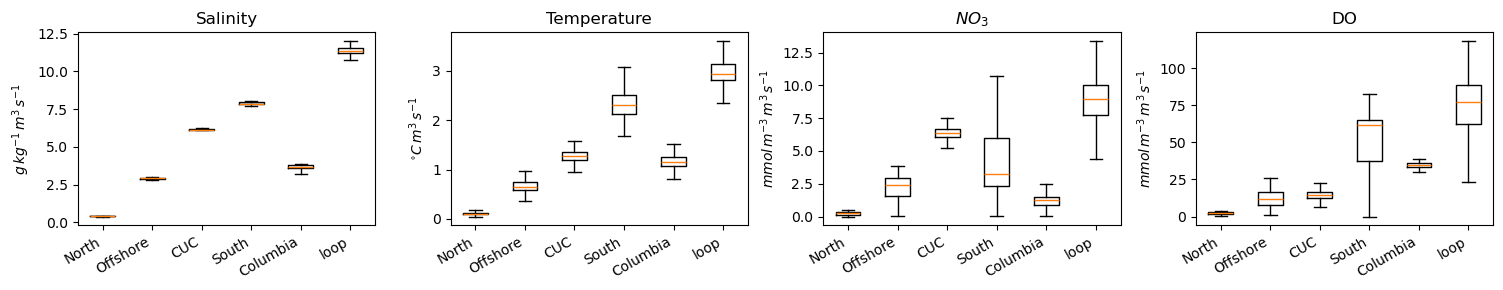

In [24]:
# same thing but normalized by mean transport
mean = [(Wnorth/total),(Woffshore/total),(Wcuc/total),(Wsouth/total),(Wcol/total),(Wloop/total)]

fig, ax = plt.subplots(1,4,figsize=(15,3))

# salt
ax[0].boxplot([winter_salt[i]*mean[i] for i in range(len(winter_tran))],showfliers=False)
ax[0].set_xticklabels(sources)
ax[0].set_title('Salinity')
ax[0].set_ylabel('$g\, kg^{-1}\, m^3\, s^{-1}$')

# temp
ax[1].boxplot([winter_temp[i]*mean[i] for i in range(len(winter_tran))],showfliers=False)
ax[1].set_xticklabels(sources)
ax[1].set_title('Temperature')
ax[1].set_ylabel('$^{\circ}C\, m^3\, s^{-1}$')

# no3
ax[2].boxplot([winter_no3[i]*mean[i] for i in range(len(winter_tran))],showfliers=False)
ax[2].set_xticklabels(sources)
ax[2].set_title('$NO_3$')
ax[2].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# oxygen
ax[3].boxplot([winter_oxy[i]*mean[i] for i in range(len(winter_tran))],showfliers=False)
ax[3].set_xticklabels(sources)
ax[3].set_title('DO')
ax[3].set_ylabel('$mmol\,m^{-3}\, m^3\, s^{-1}$')

# # year of interest
# ax[0].scatter(np.arange(6)+1, w18_salt, color='yellow', edgecolor='k', marker='*',s=100, label='Winter 2018/19')
# ax[1].scatter(np.arange(6)+1,w18_temp, color='yellow', edgecolor='k', marker='*',s=100)
# ax[2].scatter(np.arange(6)+1,w18_no3, color='yellow', edgecolor='k', marker='*',s=100)
# ax[3].scatter(np.arange(6)+1,w18_oxy, color='yellow', edgecolor='k', marker='*',s=100)

# ax[0].scatter(np.arange(6)+1,w20_salt, color='yellow',edgecolor='k',marker='o', s=60, label='Winter 2020/21')
# ax[1].scatter(np.arange(6)+1,w20_temp, color='yellow',edgecolor='k',marker='o', s=60)
# ax[2].scatter(np.arange(6)+1,w20_no3, color='yellow',edgecolor='k',marker='o', s=60)
# ax[3].scatter(np.arange(6)+1,w20_oxy, color='yellow',edgecolor='k',marker='o', s=60)

# ax[0].legend()

for axs in ax:
    axs.set_xticklabels(sources,rotation=30, ha='right')

plt.tight_layout()